Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6420 - loss: 0.6545 - val_accuracy: 0.6558 - val_loss: 0.6373
Epoch 2/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6842 - loss: 0.5895 - val_accuracy: 0.6445 - val_loss: 0.6556
Epoch 3/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7720 - loss: 0.4806 - val_accuracy: 0.6094 - val_loss: 0.8170
Epoch 4/15
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8554 - loss: 0.3586 - val_accuracy: 0.6274 - val_loss: 0.9351

Validation Accuracy: 65.58%
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.67      0.93      0.78      1326
           1       0.54      0.15      0.23       722

    accuracy                           0.66      2048
   macro avg       0.61      0.54      0.51      2048
weighted avg       0.62      0.66      0.59      2048


Test Accuracy: 65.90%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Sample Prediction: Fake (Probability: 0.4

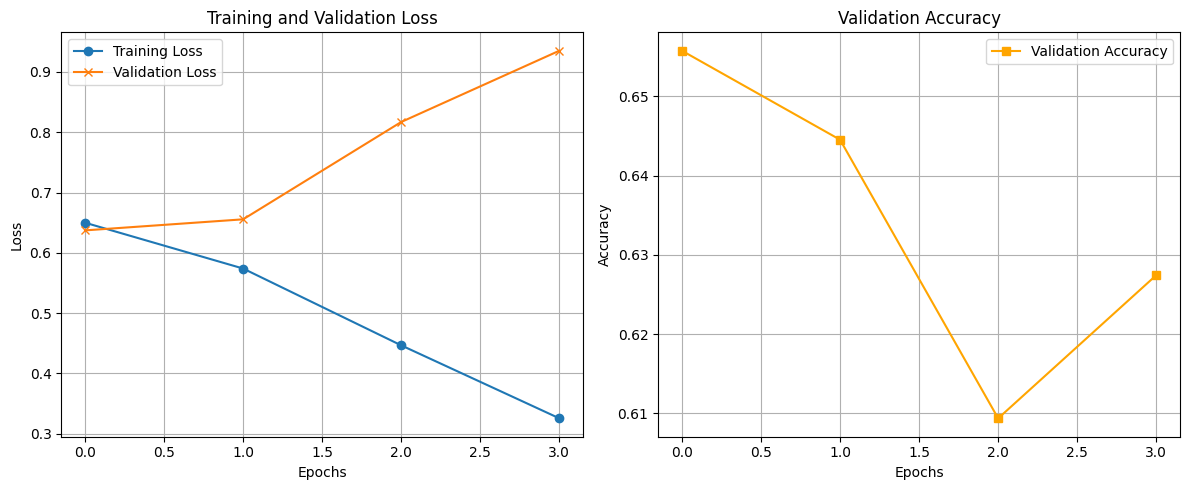

In [4]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/'

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

data = pd.read_csv(folder_path + 'train.tsv', sep='\t', header=None)
data.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
                'state_info', 'party', 'true', 'mostly_true', 'half_true',
                'barely_true', 'false', 'pants_fire']
def label_to_binary(label):
    label = label.lower().strip().replace(" ", "_").replace("-", "_")
    return 1 if label in ['true', 'mostly_true'] else 0

data['binary_label'] = data['label'].apply(label_to_binary)
texts = data['statement'].astype(str).tolist()
labels = data['binary_label'].values

def clean_text(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\s+', ' ', text).strip()
    return text
texts = [clean_text(t) for t in texts]
vocab_size = 10000
max_length = 50
oov_token = '<OOV>'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
embedding_dim = 100
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f'\nValidation Accuracy: {val_acc * 100:.2f}%')

y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_val, y_pred))

def predict_news(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_length, padding='post', truncating='post')
    prob = model.predict(padded)[0][0]
    prediction = 'Real' if prob > 0.5 else 'Fake'
    return prediction, prob

test_data = pd.read_csv(folder_path + 'test.tsv', sep='\t', header=None)
test_data.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
                     'state_info', 'party', 'true', 'mostly_true', 'half_true',
                     'barely_true', 'false', 'pants_fire']
test_data['binary_label'] = test_data['label'].apply(label_to_binary)
test_texts = test_data['statement'].astype(str).tolist()
test_labels = test_data['binary_label'].values
test_texts = [clean_text(t) for t in test_texts]
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=0)
print(f'\nTest Accuracy: {test_accuracy * 100:.2f}%')

sample_text = "The economy is growing at a steady rate with job opportunities increasing."
pred, prob = predict_news(sample_text)
print(f"Sample Prediction: {pred} (Probability: {prob:.2f})")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

import pickle
model.save("/content/drive/MyDrive/fake_news_model.h5")
with open("/content/drive/MyDrive/tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)